In [1]:
# 1/6
"""
Two-fluid model
"""

# Libraries
from fenics import *
from IPython.display import clear_output
from scipy.optimize import brenth
from scipy.linalg import eig, eigh
from scipy.sparse.linalg import eigs, eigsh
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rc
from scipy.sparse import csr_matrix
from numpy import linalg as LA
from scipy import sparse

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import logging
import ufl
%matplotlib inline

# Phase properties
c2               = 293.43                 # Sanderse 2017
u4eq             = 1e5                    # Pa, outlet pressure (equilibrium state)
rho1             = 1000                   # kg m^-3, liquid density (Montini)
rho2             = u4eq/c2**2 
rho              = (rho1 - rho2)/rho1 
mu1              = 8.9e-4                 # Pa s, liquid viscosity
mu2              = 1.8e-5                 # Pa s, gas viscosity
# sigma            = 0.072                  # Montini 2011
# force            = 74.225 #Hendrix

# Gravity
g                = 9.8 # m/s^2

# Configuration
d                = 0.078                  # m, diameter
L                = 1                      # m, pipe length
beta_deg         = 0                    
beta             = pi*beta_deg/180
Area             = pi*d**2/4. # mˆ2, total area
roughness        = 1e-8                   # m, pipe roughness

# superficial velocities (check well-posedness [as a function])
# for j1, j2 in [(0.05, 0.829), (0.5, 6.908)]:
#     print('>>> j1 = ', j1)
#     print('>>> j2 = ', j2)

# # # STABLE
j1               = 0.6            # 0.05  # 0.5      liquid superficial velocity
j2               = 10           # 0.829 # 6.908    gas superficial velocity

# UNSTABLE
# j1         = 0.5               # 0.05  # 0.5      liquid superficial velocity
# j2         = 6.908             # 0.829 # 6.908    gas superficial velocity

us               = j1 + j2            # velocity of the mixture

# # artifical diffusion coefficients (depend on superficial velocities and stability analysis)
E11              = 0.0               #0.001 
E22              = 0.0              #0.01

# FUNCTIONS
# stratification angle
def gamma (u1):
    return (pi*(1. - u1) + pow ((3.*pi/2.), (1./3.))*(2.*u1 - 1. + pow (abs (1. - u1), (1./3.))- pow (abs(u1), (1/3))))
# liquid holdup
def alpha1 (u1):
    return 1 - u1
# liquid phase velocity
def u3 (u1):
    return j1/(1. - u1)
# liquid phase velocity
def u3b (j1):
    return j1/(1. - u1)
# gas phase velocity
def u2 (u1):
    return j2/u1
# liquid sectional area
def A1 (alpha1):
    return Area*alpha1#(d**2)/4*(gamma/2 - np.sin (gamma/2)*np.cos (gamma/2))
# gas sectional area
def A2 (u1):
    return Area*u1#(d**2)/4*(pi - gamma/2 + np.sin (gamma/2)*np.cos (gamma/2))
# liquid wetted perimeter
def S1 (gamma):
    return d*gamma
# gas wetted perimeter
def S2 (gamma):
    return d*(pi - gamma)
# interface wetted perimeter
def Si (gamma):
    return d*np.sin (gamma)
# liquid hydraulic diameter 
def dh1 (A1, S1):
    return 4.*A1/S1
# gas hydraulic diameter 
def dh2 (A2, S2, Si):
    return 4.*A2/(S2 + Si)
# critic diameter
def Dc (gamma):
    return g*np.cos (beta)*pi*d/(4*np.sin (gamma))
# liquid Reynolds number
def Re1 (u3, dh1):
    return rho1*u3*dh1/mu1
# gas Reynolds number
def Re2 (u2, dh2):
    return u4eq/pow ((c2), 2)*u2*dh2/mu2
# liquid shear stress
def tauw1 (f1, u3):
    return f1*rho1*u3*abs (u3)/2.
# gas shear stress
def tauw2 (f2, u2):
    return f2*u4eq/pow (c2, 2)*u2*abs (u2)/2.
# interface shear stress
def tau21 (fi, u3, u2):
    return fi*u4eq/pow (c2, 2)*(u2 - u3)*abs (u2 - u3)/2.
# interface shear stress
def tau12 (fi, u3, u2):
    return fi*u4eq/pow (c2, 2)*(u3 - u2)*abs (u3 - u2)/2.
# liquid friction factor 1
def f1 (Re1, dh1):
    Af1 = pow (2.457*np.log(pow(pow(abs(7/Re1), 0.9) + 0.27*roughness/dh1, - 1)), 16)
    Bf1 = pow (abs (37530/Re1), 16)
    return 2*pow (pow (abs (8/Re1), 12)+pow (abs (Af1 + Bf1), - 1.5), 1/12)
# gas friction factor 2
def f2 (Re2, dh2):
    Af2 = pow (2.457*np.log(pow(pow(abs(7/Re2), 0.9) + 0.27*roughness/dh2, - 1)), 16)
    Bf2 = pow (abs (37530/Re2), 16)
    return 2*pow (pow (abs (8/Re2), 12)+pow (abs (Af2 + Bf2), - 1.5), 1/12)
# interfacial friction
def fi (f2):
    return max (f2, 0.014)
# steady state momentum equation
def equilibrium1 (u1): 
    func = - (rho1 - u4eq/pow (c2, 2))*g*np.sin (beta) - tauw1 (f1 (Re1 (u3 (u1), dh1 (A1 (alpha1 (u1)), S1 (gamma (u1)))), dh1 (A1 (alpha1 (u1)), S1 (gamma (u1)))), u3 (u1))*S1 (gamma (u1))/A1 (alpha1(u1)) + tauw2 (f2 (Re2 (u2 (u1), dh2 (A2 (u1), S2 (gamma (u1)), Si (gamma (u1)))), dh2 (A2 (u1), S2 (gamma (u1)), Si (gamma (u1)))), u2 (u1))*S2 (gamma (u1))/A2(u1) + tau21 (fi (f2 (Re2 (u2 (u1), dh2 (A2 (u1), S2 (gamma (u1)), Si(gamma (u1)))), dh2 (A2 (u1), S2 (gamma (u1)), Si (gamma (u1))))), u3 (u1), u2 (u1))*Si(gamma (u1))*((1/A1 (alpha1 (u1))) + (1/A2 (u1)))
    return func

# Void fraction equilibrium
lima    = 1e-15
limb    = 1 - lima
u1eq    = brenth (equilibrium1, lima, limb)

# messages for void fraction and Reynolds
print ("Void fraction = ", u1eq)
print (" ")
print ("Reynolds 1    = ", Re1 (u3 (alpha1 (u1eq)), dh1 (A1 (alpha1 (u1eq)), S1 (gamma (u1eq)))))
print ("Reynolds 2    = ", Re2 (u2 (alpha1 (u1eq)), dh2 (A2 ( u1eq), S2 (gamma (u1eq)), Si (gamma (u1eq)))))
print (" ")
# parameters used in boundary conditions
u1_0     = u1eq
u2_0     = u2 (u1eq)
u3_0     = u3 (u1eq)
u4_0     = u4eq
# messages for boundary conditions just at the entrance, but not the actual base flow)
print ("Boundary conditions phi (t, x)")
print ("Gas void fraction    : u1_0 (t, 0) = ", u1_0, "[-]")
print ("Gas velocity         : u2_0 (t, 0) = ", u2_0, "[m/s]")
print ("Liquid velocity      : u3_0 (t, 0) = ", u3_0, "[m/s]")
print ("Interfacial pressure : u4_0 (t, L) = ", u4_0, "Pa")
print (" ")
print ("Liquid holdup    = ", 1 - u1_0, "[-]")
print ("Liquid velocity  = ", u3_0, "[m/s]")

Void fraction =  0.5438451525684794
 
Reynolds 1    =  92241.14265374072
Reynolds 2    =  71483.18871290053
 
Boundary conditions phi (t, x)
Gas void fraction    : u1_0 (t, 0) =  0.5438451525684794 [-]
Gas velocity         : u2_0 (t, 0) =  18.38758689448984 [m/s]
Liquid velocity      : u3_0 (t, 0) =  1.3153428125962727 [m/s]
Interfacial pressure : u4_0 (t, L) =  100000.0 Pa
 
Liquid holdup    =  0.45615484743152057 [-]
Liquid velocity  =  1.3153428125962727 [m/s]


In [2]:
# # https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html

# print(type(d))
# print(type(beta))
# print(type(rho2))
# print(type(u1_0))
# print(type(u2_0))
# print(type(u3_0))
# print(type(u4_0))
# # print(type(epstest))

# def transform (variable):
#     return np.float32(variable)

# c2               = transform(c2)                # Sanderse 2017
# u4eq             = transform(u4eq)                    # Pa, outlet pressure (equilibrium state)
# rho1             = transform(rho1)                   # kg m^-3, liquid density (Montini)
# rho2             = transform(rho2) 
# rho              = transform(rho) 
# mu1              = transform(mu1)                # Pa s, liquid viscosity
# mu2              = transform(mu2)                 # Pa s, gas viscosity

# d                = transform(d)                 # m, diameter
# L                = transform(L)                       # m, pipe length
# beta             = transform(beta) 
# Area             = transform(Area) 
# roughness        = transform(roughness)                    # m, pipe roughness

# j1               = transform(j1)                # 0.05  # 0.5      liquid superficial velocity
# j2               = transform(j2)               # 0.829 # 6.908    gas superficial velocity
# us               = transform(us)             # velocity of the mixture

# E11              = transform(E11)                #0.001 
# E22              = transform(E22) 

# u1_0             = transform(u1_0) 
# u2_0             = transform(u2_0) 
# u3_0             = transform(u3_0) 
# u4_0             = transform(u4_0) 

# # epstest          = transform(epstest) 
# # print(DOLFIN_EPS)

In [3]:
# 2/5

# FEniCS configuration
#set_log_level(1) # Progress: to get as much information as possible we will set the log level to 1, but it can be 16
#set_log_level (LogLevel.TRACE)

# # Choose linear algebra backend    
#parameters["linear_algebra_backend"] = "PETSc"

# Form compiler options
# ffc_options = {"optimize"               : True, \
#                "eliminate_zeros"        : False, \
#                "precompute_basis_const" : True, \
#                "precompute_ip_const"    : True,
#                "quadrature_degree": 4}

# Form compiler options
parameters ['form_compiler']['representation'] = 'uflacs'
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
#parameters ["form_compiler"]['precision'] = 15
#parameters["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"
# parameters ["form_compiler"]["quadrature_degree"] = 8

# (4 for elasticity) (8 for multiphase flow)
# http://www.karlin.mff.cuni.cz/~hron/fenics-tutorial/multiphase/doc.html MULTIPHASE FLOW""""""

# Allow approximating values for points that may be generated outside of domain (because of numerical inaccuracies)
#parameters["allow_extrapolation"] = True
#parameters["refinement_algorithm"] = "plaza_with_parent_facets"

# Define constants
var1bc1   = Constant(1 - u1_0)                    # alpha1           1 - u1_0
var2bc1   = Constant(u3_0)                        # u1               u3_0
L         = Constant(L)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > - DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - 1.0
        
# Define space discretization properties
xmin      = 0
xmax      = L
nx        = 40                            # no. of elements 100 to 1600
p         = 2                              # degree of FEM
mesh      = IntervalMesh (nx, xmin, xmax)

# Save mesh
File ("tfm_1/mesh.xml") << mesh

V1         = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p-1)
V2         = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p)
element    = MixedElement ([V1, V2])
V          = FunctionSpace(mesh, element, constrained_domain = PeriodicBoundary())

# Define test and trial functions
v1, v2     = TestFunctions (V)
var        = Function(V)
var1, var2 = split (var)
dvar       = TrialFunction (V)

# Sub domain for Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (1.0 - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS

bc1     = DirichletBC(V.sub (0), var1bc1, left)
bc2     = DirichletBC(V.sub (1), var2bc1, left)
bcs     = [bc1, bc2]

# Define initial conditions
class InitialConditions (UserExpression):
    def eval (self, values, x):
        values[0] = var1bc1
        values[1] = var2bc1 
    def value_shape (self):
        return (2,)

var_ic                         = InitialConditions (degree = p)
var_n                          = interpolate (var_ic, V) 
var1_n, var2_n, = split (var_n)

In [4]:
E11       = Constant (E11)
E22       = Constant (E22)
g         = Constant (g)
Area      = Constant (Area)
rho1      = Constant (rho1)
rho2      = Constant (rho2)
rho       = Constant (rho)
rho1      = Constant (rho1)
mu1       = Constant (mu1)
mu2       = Constant (mu2)
c2        = Constant (c2)
d         = Constant (d)
roughness = Constant (roughness)
us        = Constant (us)
beta1     = Expression ("beta*x[0]", degree = p, beta = beta)              

epstest          = DOLFIN_EPS

# For UFL
def Max (a, b): 
    return (a + b + abs (a - b))/2
                    
def Min (a, b):
    return (a + b - abs (a - b))/2

def gamma (var1,var2):
    term0 = pi*(var1 + epstest) + (3*pi/2)**(1/3)*(1-2*(var1 + epstest)+((var1 + epstest))**(1/3)-((1-(var1 + epstest)))**(1/3))
#     term0 = 1.55517 + 1.56314* ((var1 + epstest) - var1bc1)
    return term0

# Define functions used in weak form
def A11 (var1, var2):
    term1 = var2 + epstest
    return term1

def A12 (var1, var2):
    term2 = var1 + epstest
    return term2

def A21 (var1, var2):
    Si     = (d*sin (gamma(var1,var2)))
    term3  = 1/(1 - rho*(var1 + epstest))*((Area*cos(beta)*(1 - (var1 + epstest))*g*rho)/Si + (rho - 1)*((var2 + epstest)**2) - (rho2/rho1*(us - (var1 + epstest)*(var2 + epstest))*(us - (2 - (var1 + epstest))*(var2 + epstest)))/((1 - (var1 + epstest))**2))
    return term3
    
def A22 (var1, var2):
    term4  = 1/(1 - rho*(var1 + epstest))*(((var2 + epstest)*(1 - 2*(var1 + epstest) + rho*(var1 + epstest))) - ((2*rho2*(var1 + epstest)*(us - (var1 + epstest)*(var2 + epstest))/rho1)/(1 - (var1 + epstest))))
    return term4

def D2 (var1, var2):
    alpha2 = 1 - (var1 + epstest)

    S1    = d*gamma(var1,var2)
    S2    = d*(pi - gamma(var1,var2))
    S21   = d*sin (gamma(var1,var2))
    
    dh1   = 4*(var1 + epstest)*Area/S1
    dh2   = 4*(alpha2)*Area/(S2 + S21)
    
    vel2  = (us - (var1 + epstest)*(var2 + epstest) )/(1 - (var1 + epstest))

    S1    = d*gamma(var1,var2)/2
    
    f1    = 0.046*pow(abs(abs(var2 + epstest)*dh1*rho1/mu1), - 0.2)
    tau1  = f1*rho1*(var2 + epstest)*abs (var2 + epstest)/2.
    
    f2    = 0.046*pow(abs(abs(vel2)*dh2*rho2/mu2), - 0.2)
    tau2  = f2*rho2*vel2*abs (vel2)/2.
    
    f21    = Max (f2, 0.014)
    tau21  = f21*rho2*(vel2 - (var2 + epstest))*abs (vel2 - (var2 + epstest))/2.
    
    term5 = 1/(1 - rho*(var1 + epstest))*(((var1 + epstest)*(tau2*S2 - tau1*S1) + (tau21*S21))/(rho1*(var1 + epstest)*Area) + (1 - (var1 + epstest))*g*rho*sin (beta))
    return term5
    

In [5]:
# #phase velocities
# us        = Constant (us)
# #fluid properties
# rho1      = Constant (rho1)
# rho2      = Constant (rho2)
# rho       = Constant (rho)
# mu1       = Constant (mu1)
# mu2       = Constant (mu2)
# #geometry
# d         = Constant (d)
# Area      = Constant (Area)
# beta1     = Expression ("beta*x[0]", degree = p, beta = beta)              
# #gravity
# g         = Constant (g)
# #numerical viscosity
# E11       = Constant (E11)
# E22       = Constant (E22)
# #eps for precision
# epstest          = DOLFIN_EPS

# # Define functions used in weak form
# def Max (a, b): 
#     return (a + b + abs (a - b))/2             
# def Min (a, b):
#     return (a + b - abs (a - b))/2
# def gamma (var1):
# #     term0 = pi*(var1 + epstest) + (3*pi/2)**(1/3)*(1-2*(var1 + 0*epstest)+((var1 + epstest))**(1/3)-((1-(var1 + 0*epstest)))**(1/3))
#     term0 = 1.55517 + 1.56314* ((var1) - var1bc1)
#     return term0
# def A11 (var1, var2):
#     term1 = var2 
#     return term1
# def A12 (var1, var2):
#     term2 = var1 
#     return term2
# def A21 (var1, var2):
#     Si     = (d*sin (gamma(var1)))
#     term3  = 1/(1 - rho*(var1))*((Area*cos(beta)*(1 - (var1))*g*rho)/Si + (rho - 1)*pow((var2), 2) - (rho2/rho1*(us - (var1)*(var2) )*(us - (2 - (var1))*(var2)))/pow ((1 - (var1)), 2))
#     return term3
#     #conditional(lt(abs(q),eps),(1.0/eps)*0.5*(1.0+cos(3.14159*q/eps)),Constant(0.0))
# def A22 (var1, var2):
#     term4  = 1/(1 - rho*(var1))*(((var2)*(1 - 2*(var1) + rho*(var1))) - ((2*rho2*(var1)*(us - (var1)*(var2))/rho1)/(1 - (var1))))
#     return term4
# def D2 (var1, var2):
#     S1    = d*gamma(var1)
#     S2    = d*(pi - gamma(var1))
#     S21   = d*sin (gamma(var1))
    
#     dh1   = 4*(var1)*Area/S1
#     dh2   = 4*(1 - var1)*Area/(S2 + S21)
    
#     vel2  = (us - (var1)*(var2) )/(1 - (var1))

#     S1    = d*gamma(var1)/2
    
#     f1    = 0.046*(((var2)*dh1*rho1/mu1) + epstest)**(-1/5)
#     tau1  = f1*rho1*(var2)*(var2)/2.
    
#     f2    = 0.046*(((vel2)*dh2*rho2/mu2)**( - 1/5))
#     tau2  = f2*rho2*vel2*(vel2)/2.
        
#     f21    = Max (f2, 0.014)
#     tau21  = f21*rho2*(vel2 - (var2))*abs (vel2 - (var2))/2.
    
#     term5 = 1/(1 - rho*(var1))*(((var1)*(tau2*S2 + tau1*S1) - (tau1*S1) + (tau21*S21))/(rho1*(var1 + epstest)*Area) + (1 - (var1))*g*rho*sin (beta))
#     return term5
    

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


<function matplotlib.pyplot.show(*args, **kw)>

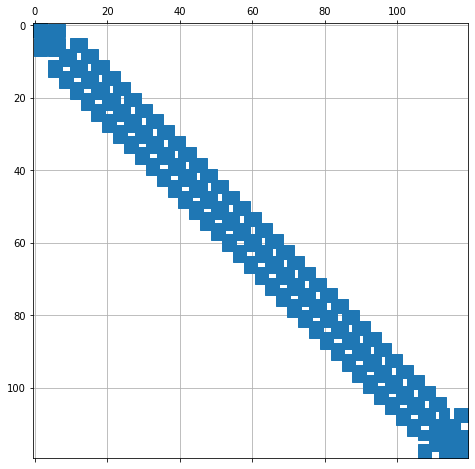

In [6]:
# Define weak form (semi distretised with artificial difussion)
F = ( - A11 (var1, var2)*Dx(var1,0)*v1\
      - A12 (var1, var2)*Dx(var2,0)*v1\
      + inner(E11*grad(var1),grad(v1))\
      - A21 (var1, var2)*Dx(var1,0)*v2\
      - A22 (var1, var2)*Dx(var2,0)*v2\
      + inner(E22*grad(var2),grad(v2))\
      + D2 (var1, var2)*v2              )*dx

# Auxiliary
L = (Constant(0)*v1 + Constant(0)*v2)*dx

# Define Jacobian
dF = derivative (F, var, dvar)

# Assemble stiffness form    
A = PETScMatrix()
b = PETScVector()

assemble_system(dF, L, bcs, A_tensor = A, b_tensor = b)

A_mat = as_backend_type(A).mat()

# Transform to numpy array
A_sparray = csr_matrix(A_mat.getValuesCSR()[::-1], shape = A_mat.size)

# Print array

# print(A_sparray)

# Plot array
plt.figure (3, figsize = (12, 8))
plt.spy(A_sparray)
plt.grid (True, which = "both")
# plt.rcParams ['figure.figsize'] = [12, 8]

plt.show


In [7]:
# Make Sparse matrix complex and convert it to array
Acomplex_sparse = A_sparray.dot (1j)
Asparraycomplex = A_sparray.toarray ()

# Convert sparse matrix to array and make it complex
Aeval           = A_sparray.toarray ()
Aevalcomplex    = Aeval.dot (1j)

Computing eigenvalues. This can take a minute.
real      = 123201013678080.0
real      = -123201006075904.0
real      = -26032123676149.965
real      = 26032122232789.42
real      = -25094664641570.492
real      = 25094664004983.863
real      = 4662218414349.842
real      = 4662218414349.842
real      = -4662220003378.432
real      = -4662220003378.432
real      = -22526691841124.473
real      = 22526690547272.78
real      = -749002.1078874774
real      = -749002.1078874774
real      = -21456908991498.938
real      = 21456907064041.08
real      = -598039.6934508481
real      = -598039.6934508481
real      = -8556670504190.04
real      = -8556670504190.04
real      = 8556669132314.333
real      = 8556669132314.333
real      = -17380270841123.273
real      = -17380270841123.273
real      = 17380268042010.996
real      = 17380268042010.996
real      = -15072297244779.617
real      = -15072297244779.617
real      = 15072295921902.473
real      = 15072295921902.473
real      = -173368454888

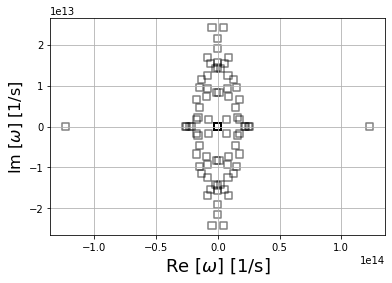

In [8]:
# ALTERNASTIVE 1

# print('111= ',Asparraycomplex)
# print('222= ',Aevalcomplex)

# print('resta= ', Asparraycomplex-Aevalcomplex)

# print("Condition number :", LA.cond(Aeval))
# print('Is symmetric :', np.linalg.norm(A.array() - A.array().T) < 1E-10)

# def is_pos_def(x):
#     return np.all(np.linalg.eigvals(x) > 0)

# print('Is positive definite :', is_pos_def(Aeval))
# print('Recommended BiCGStab and GMRES. GMRES has a parameter -the number of search vectors- that may be tuned.')

# vals, vecs = eigs ( - Acomplex_sparse) #alternative1


eigensolver = SLEPcEigenSolver (A)
print("Computing eigenvalues. This can take a minute.")
eigensolver.solve ()

listreal = []
listimag = []

for ii in range(eigensolver.get_number_converged()):
    r, c, rx, cx = eigensolver.get_eigenpair(ii)
#     print ("i = ", ii)
    print ("real      =", r)
    listreal.append (r)

#     print ("imaginary =", c)
    listimag.append (c)

# Extract largest (first) eigenpair
r, c, rx, cx = eigensolver.get_eigenpair(0)

# print("Largest eigenvalue: ", r)
            
# Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

# Plot eigenspectra 1
fig, ax = plt.subplots ()
area = 50

ax.scatter (listreal, listimag, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
# ax.set_xscale ('symlog', linthreshx = 1e-4)

plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)

matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

# plt.ylim (( - 0.002 , ))
# plt.xlim (( 2*vals.real[localminreal[0]], 2*vals.real[localmaxreal[0]]))
# plt.show ()    

realvals =  [-4.03851357e+05 -4.05799596e+05 -4.09035848e+05 -4.13543953e+05
 -4.19301403e+05 -4.26279452e+05 -4.34443266e+05 -4.43752088e+05
 -4.54159438e+05 -5.52771790e+05 -4.78056511e+05 -4.65613330e+05
 -5.05656923e+05 -4.91426715e+05 -5.20675636e+05 -5.36407144e+05
 -5.69686227e+05 -6.77639950e+05 -5.87063652e+05 -6.04814023e+05
 -6.22844239e+05 -6.41058291e+05 -6.59357374e+05 -6.95801783e+05
 -7.13735928e+05 -7.31332708e+05 -7.48479690e+05 -7.65061696e+05
 -7.80960911e+05 -7.96057142e+05 -8.10228337e+05 -8.76218662e+05
 -8.35303806e+05 -8.45964982e+05 -8.23351454e+05 -8.73529491e+05
 -8.62959547e+05 -8.55219408e+05 -8.69089604e+05 -1.40339094e+06
 -1.40375083e+06 -1.40482102e+06 -1.40657369e+06 -1.40896487e+06
 -1.41193751e+06 -1.41542523e+06 -1.41935603e+06 -1.42365584e+06
 -1.42825142e+06 -1.43307267e+06 -1.44826543e+06 -1.44313627e+06
 -1.45339446e+06 -1.45848228e+06 -1.46349358e+06 -1.43805418e+06
 -1.46839834e+06 -1.47317137e+06 -1.47779171e+06 -1.48650878e+06
 -1.48224216e

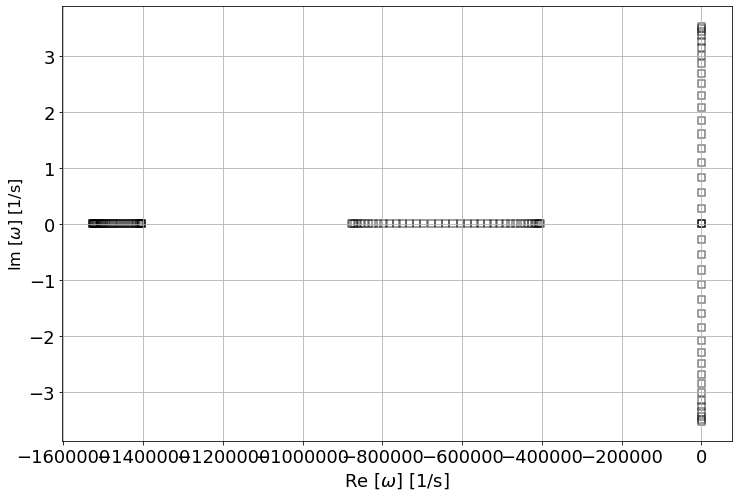

In [9]:
# ALTERNATIVE 2
vals, vecs = eig ( Aeval, overwrite_a = True) #alternative1 ---------------------------------

# Eigenvalues
imagvals = vals.imag
realvals = vals.real

print("realvals = ", vals.real)
# print("imagvals = ", vals.imag)

# Eigenvectors
imagvecs = vecs.imag
realvecs = vecs.real

# print("realvecs = ", vecs.real)
# print("imagvecs = ", vecs.imag)

# Largest eigenvalues and eigenvectors localization
localmaxreal = np.where(vals.real == vals.real.max())
localmaximag = np.where(vals.imag == vals.imag.max())

# Largest eigenvalues and eigenvectors localization
localminreal = np.where(vals.real == vals.real.min())
localminimag = np.where(vals.imag == vals.imag.min())

# print("localmaxreal =", localmaxreal)
# print("localmaximag =", localmaximag)

# print("localminreal =", localminreal)
# print("localminimag =", localminimag)

# print("min eigenvalue real = ", vals.real[localminreal[0]])
print("max eigenvalue real = ", vals.real[localmaxreal[0]])

eigenvector_real = vecs.real[localmaxreal[0]]
eigenvector_imag = vecs.imag[localmaximag[0]]

#     print("eigenvector_real =", eigenvector_real[0])
#     print("eigenvector_imag =", eigenvector_imag[0])

# Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

# Plot eigenspectra 1
fig, ax = plt.subplots ()
area = 50

ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
# ax.set_xscale ('symlog', linthreshx = 1e-4)

plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)

matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

# plt.ylim (( - 0.002 , ))
# plt.xlim (( 2*vals.real[localminreal[0]], 2*vals.real[localmaxreal[0]]))
plt.show ()    

# # Eigenvectors
# # Plot real eigenvectors
# ureal  = Function(V)
# ureal.vector()[:] = eigenvector_real[0] #len(vecs)-1 
# u1real, u2real= ureal.split()

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u1real, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u2real, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

#     # Plot eigenfunction
#     plt.figure (3, figsize = (12, 8))
#     plot(u3real, wireframe = True, title = 'Eigenfunction')
#     plt.grid (True, which = "both")
#     plt.xlabel("L")
#     plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

#     # Plot eigenfunction
#     plt.figure (3, figsize = (12, 8))
#     plot(u4real, wireframe = True, title = 'Eigenfunction')
#     plt.grid (True, which = "both")
#     plt.xlabel("L")
#     plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

    # # Plot imaginary eigenvectors
    # uimag = Function(V)
    # uimag.vector()[:] = eigenvector_imag[0] #eigenfunction)
    # u1imag, u2imag, u3imag, u4imag = uimag.split()
    # 
    # # Plot eigenfunction
    # plt.figure (4, figsize = (12, 8))
    # plot(u1imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

    # plt.figure (4, figsize = (12, 8))
    # plot(u2imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

    # plt.figure (4, figsize = (12, 8))
    # plot(u3imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

    # plt.figure (4, figsize = (12, 8))
    # plot(u4imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

plt.show()

# SAVE LARGEST REAL
# File("slugging_test/eigenmodesu1_real.pvd") << u1real
# File("slugging_test/eigenmodesu2_real.pvd") << u2real
#     File("slugging/eigenmodesu3_real.pvd") << u3real
#     File("slugging/eigenmodesu4_real.pvd") << u4real

# # SAVE LARGEST IMAGINARY
# File("slugging/eigenmodesu1_imag.pvd") << u1imag
# File("slugging/eigenmodesu2_imag.pvd") << u2imag
# File("slugging/eigenmodesu3_imag.pvd") << u3imag
# File("slugging/eigenmodesu4_imag.pvd") << u4imag

(0, 10.0)

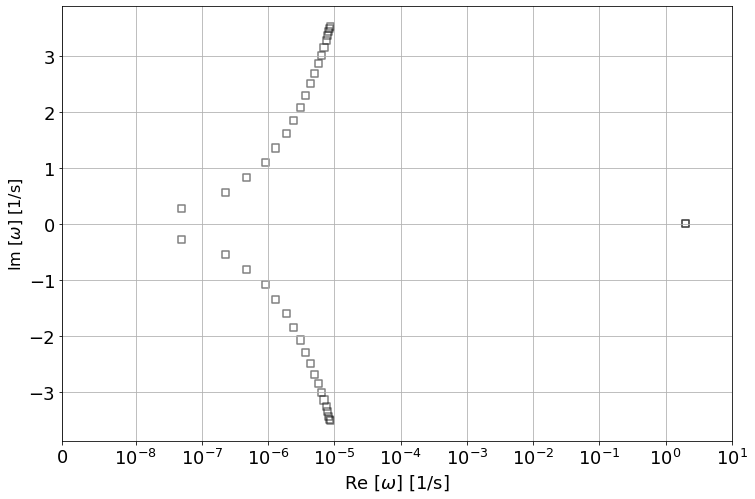

In [10]:
#####

# Plot eigenspectra 2
fig, ax = plt.subplots ()
area = 50

ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
ax.set_xscale ('symlog',  linthreshx = 1e-8)

# ax.xaxis.set_minor_locator(MultipleLocator(1e-15))
plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
        
matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

plt.xlim (0 , 1e1)
# plt.xlim (( - 5*realvals[localmaxreal[0][0]], 5*realvals[localmaxreal[0][0]])) #primeriro teste
# plt.xlim (( - 1e-12, 1e-12))

#####


In [23]:
deltax=d/2

# Define time discretization properties
T         = 1.0                        # 1 cycle = 2*pi/k = 1 s (according to Hendrix)
CFL       = 0.9875                        # 0.7 Holmas, 0.978 Van Zwieten
dt        = CFL*deltax/(var2bc1)        # Van Zwieten & Smith /lambda_max Holmas (maximum modulus of the eigenvalues of the Jacobian of (4.1) at time step n)
                                        # Update u1
num_steps = int(round (T/dt))

# messages time discretization 
print('T         =', T)
print('dt        =', dt)
print('num_steps =', num_steps)

# Constants for initial conditions
k_wave     = 2*pi  #Hendrix
omega_wave = 8.484 #Hendrix

k_wave     = Constant(k_wave)
omega_wave = Constant(omega_wave)
t          = 0

# Define initial conditions
class InitialConditions (UserExpression):
    def eval (self, values, x):
        values[0] = var1bc1 + 0.01*sin(k_wave*x[0] - omega_wave*t) 
        values[1] = var2bc1 + 7e-3*sin(k_wave*x[0] - omega_wave*t)

    def value_shape (self):
        return (2,)

var_ic                         = InitialConditions (degree = p)
var_n                          = interpolate (var_ic, V) 
var1_n, var2_n, = split (var_n)


T         = 1.0
dt        = 0.9875 * f_1290 / 2 / f_1
num_steps = 3


In [71]:
k = Constant (dt)

# Define weak form (semi distretised transient with artificial difussion)
F1 = ( ((var1 - var1_n) / k)*v1\
     + A11 (var1, var2)*v1*Dx(var1,0)\
     + A12 (var1, var2)*(v1*Dx(var2,0))\
     - (inner(E11*grad(var1), grad(v1)))\
     + ((var2 - var2_n) / k)*v2\
     + A21 (var1, var2)*v2*Dx(var1,0)\
     + A22 (var1, var2)*v2*Dx(var2,0)\
     - inner(E22*grad(var2), grad(v2))\
     - D2 (var1, var2)*v2 )*dx

# Define Jacobian
dF1 = derivative (F1, var, dvar)

# Define files
ff1 = File ("tfm_simplified_reuniao/var1.pvd", "compressed")
ff2 = File ("tfm_simplified_reuniao/var2.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time
    t += dt
#     u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F1, var, bcs = bcs, J = dF1, form_compiler_parameters = ffc_options)
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1E-18
    prm ['newton_solver']['convergence_criterion']   = 'residual' #'residual'
#     prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'gmres'       # 'gmres' 'ml_amg' 'mumps' 'superlu_dist'
#     #mumps for singular problems
#     # superlu: paralelizable
    prm ['newton_solver']['maximum_iterations']      = 1000
    prm ['newton_solver']['preconditioner']          = 'ilu' #ilu
    prm ['newton_solver']['relative_tolerance']      = 1E-20
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1E-3 #1E-9
    prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 50000 # 500000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1E-3
    prm ['newton_solver']['krylov_solver']['report']                   = True
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = False
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 16
    set_log_level(PROGRESS)
    
    solver.solve()

    (var1,var2) = u.split (deepcopy = True)
    
    # Plot solution
    plt.figure (1, figsize = (8, 4))
    #plt.clf()
    plot (var1, title = "Liquid holdup") #plot alpha from 0.5 to 0.9
    
    plt.figure (2, figsize = (8, 4))
    #plt.clf()
    plot (var2, title = "Liquid velocity")
             
    # Update previous solution
    u_n.assign (var)
    
    # Save solution
    ff1 << var1
    ff2 << var2


print(parameters.linear_algebra_backend)

# Show all timings
list_timings(TimingClear.clear, [TimingType.wall])

# Hold plot
plt.show ()

# # Show time of the program's execution
# start_time  = time.time ()
# if __name__ == '__main__':
#     print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    

Iteration : 0.9875 * f_371 / 2 / f_344 / 0.9875 * f_371 / 2 / f_344 of 3
Time      : 0.9875 * f_371 / 2 / f_344 s


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve linear system using PETSc Krylov solver.
*** Reason:  Solution failed to converge in 0 iterations (PETSc reason DIVERGED_NANORINF, residual norm ||r|| = 0.000000e+00).
*** Where:   This error was encountered inside PETScKrylovSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------
